In [1]:
import pickle
import cv2
from PIL import Image
from retinaface import RetinaFace
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import VGG_Face
import os
from os import listdir
from os.path import isfile, join
import shutil
import heapq

In [2]:
class face_clustering:
    def __init__(self,input_images_path,model_weights_path,threshold = 0.55,update_threshold = 0.3,first_match = True,model_name = 'VGGface'):
        self.image_path = input_images_path
        self.model_weights_path = model_weights_path
        self.threshold = threshold
        self.update_threshold = update_threshold
        self.first_match = first_match
        self.model_name = model_name
        self.model = VGG_Face.load_model(model_weights_path)
        self.image_dict = defaultdict(set)
        self.face_id_mapping = {}
        self.new_face_id = 1
        self.image_files = self.fetch_images()
        self.create_clusters(self.image_files)
        
    def fetch_images(self):
        image_path = self.image_path
        return [f for f in listdir(image_path) if isfile(join(image_path, f)) and f.split('.')[-1] in ["jpg", "jpeg", "png", "bmp", "webp"]]

    def create_clusters(self,image_files):
        image_path = self.image_path
        for image_id in image_files:
            print(image_id)
            img = cv2.imread(image_path+image_id)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            self.map_image(img,image_id)

    def fetch_faces(self,img):
        if self.model_name == 'VGGface':
            size = (224,224)
        elif self.model_name == 'facenet':
            size = (160,160)
        elif self.model_name == 'arcface':
            size = (112,112)
        detected_faces = RetinaFace.detect_faces(img,threshold=0.98)
        faces = []
        for f in detected_faces:
            y1,x1,y2,x2 = detected_faces[f]['facial_area']
            face = img[x1:x2,y1:y2]
            face = cv2.resize(face,size)
            faces.append(face)
        return faces
        
    def get_embedding(self,face):
        face = np.expand_dims(face,axis=0)
        face = (face.astype(np.float32) / 255.0).astype(np.float32)
        embs = self.model.predict(face)
        return embs[0]

    def find_euclidean_distance(self,source_representation,test_representation):
        euclidean_distance = source_representation - test_representation
        euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
        euclidean_distance = np.sqrt(euclidean_distance)
        return euclidean_distance
    
    def find_cosine_distance(self,source_representation, test_representation):
        a = np.matmul(np.transpose(source_representation), test_representation)
        b = np.sum(np.multiply(source_representation, source_representation))
        c = np.sum(np.multiply(test_representation, test_representation))
        return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

    def update_face_embs(self,face_id,face_emb,face):
        curr_emb = self.face_id_mapping[face_id][0]
        num_faces = self.face_id_mapping[face_id][1]
        new_emb = (curr_emb*num_faces + face_emb)/(num_faces+1)
        self.face_id_mapping[face_id][0] = new_emb
        self.face_id_mapping[face_id][1] = num_faces+1
        #self.face_id_mapping[face_id][3].append(face)
        
    def map_image(self,img,img_id,update_embs=True):
        '''
        if self.model_name=='VGGface':
            update_threshold = 0.4
            threshold = 0.55
        elif model_name == 'facenet':
            update_threshold = 0.5
        elif model_name == 'arcface':
            update_threshold = 0.5    
            
        # base_threshold = {"cosine": 0.40, "euclidean": 0.55, "euclidean_l2": 0.75}
        # "VGG-Face": {"cosine": 0.40, "euclidean": 0.60, "euclidean_l2": 0.86}, # 2622d
        # "VGG-Face": { "cosine": 0.68,"euclidean": 1.17,"euclidean_l2": 1.17,},  # 4096d - tuned with LFW
        # "Facenet512": {"cosine": 0.30, "euclidean": 23.56, "euclidean_l2": 1.04},
        # "ArcFace": {"cosine": 0.68, "euclidean": 4.15, "euclidean_l2": 1.13},
        '''
        faces = self.fetch_faces(img)
        print('num faces :',len(faces))
        for face in faces:
            face_emb = self.get_embedding(face)
            found = False
            min_dist = float('inf')
            for face_id in self.face_id_mapping:
                key_emb = self.face_id_mapping[face_id][0]
                dist = self.find_cosine_distance(key_emb,face_emb)
                if dist <= self.threshold:
                    found = True
                    if dist < min_dist:
                        min_dist = dist
                        min_face_id = face_id
                    if self.first_match:
                        break
            if not found:
                face_id = self.new_face_id
                self.face_id_mapping[face_id] = [face_emb,1,face]#,[face]]
                self.image_dict[face_id].add(img_id)
                self.new_face_id += 1
            else:
                self.image_dict[min_face_id].add(img_id)
                if min_dist <= self.update_threshold and update_embs: 
                    self.update_face_embs(min_face_id,face_emb,face)

    def plot_faces(self):
        plt.figure(figsize=(12,5))
        num_plots = len(self.face_id_mapping)
        for i,id in enumerate(self.face_id_mapping):
            plt.subplot(1,num_plots,i+1).imshow(self.face_id_mapping[id][2])
            plt.subplot(1,num_plots,i+1).title.set_text(str(id))
            plt.axis('off')
        plt.show()
        
    def plot_faces2(self):
        #plot based on similarities
        plt.figure(figsize=(12,5))
        distances = []
        face_ids = list(self.face_id_mapping.keys())
        num_plots = len(face_ids)
        for i in range(num_plots-1):
            for j in range(i+1,num_plots):
                face_id1 = face_ids[i]
                face_id2 = face_ids[j]
                dist = self.find_cosine_distance(self.face_id_mapping[face_id1][0],self.face_id_mapping[face_id2][0])
                heapq.heappush(distances,[dist,face_id1,face_id2])
        plotted = set()
        i = 1
        while i<= num_plots:
            for id in heapq.heappop(distances)[1:]:
                if id not in plotted:
                    plt.subplot(1,num_plots,i).imshow(self.face_id_mapping[id][2])
                    plt.subplot(1,num_plots,i).title.set_text(str(id))
                    plt.axis('off')
                    plotted.add(id)
                    i+=1
        plt.show()

    def merge_faces(self,face_ids,merge_weights=False):
        curr = face_ids[0]
        for i in face_ids[1:]:
            curr = self.merge_two_faces(curr,i,merge_weights)
        self.plot_faces2()

    def merge_two_faces(self,face_id1,face_id2,merge_weights=False):
        images1 = self.image_dict[face_id1]
        images2 = self.image_dict[face_id2]
        num_images1 = len(images1)
        num_images2 = len(images2)
        emb1,num_faces1,face1,faces1 = self.face_id_mapping[face_id1]+['']
        emb2,num_faces2,face2,faces2 = self.face_id_mapping[face_id2]+['']
        if (num_images1,num_faces1) >= (num_images2,num_faces2):
            new_emb = emb1
            num_faces = num_faces1
            face = face1
            #faces = faces1
            keep = face_id1
            drop = face_id2
        else:
            new_emb = emb2
            num_faces = num_faces2
            face = face2
            faces = faces2
            keep = face_id2
            drop = face_id1
        if merge_weights:
            num_faces = num_faces1+num_faces2
            #faces = faces1+faces2
            new_emb = self.merge_two_face_embs(face_id1,face_id2)
        self.face_id_mapping[keep] = [new_emb,num_faces,face]#,faces]
        self.image_dict[keep] = images1|images2
        del self.image_dict[drop]
        del self.face_id_mapping[drop]
        #self.plot_faces()
        return keep

    def merge_two_face_embs(self,face_id1,face_id2):
        emb1 = self.face_id_mapping[face_id1][0]
        num_faces1 = self.face_id_mapping[face_id1][1]
        emb2 = self.face_id_mapping[face_id2][0]
        num_faces2 = self.face_id_mapping[face_id2][1]
        return (emb1*num_faces1 + emb2*num_faces2)/(num_faces1+num_faces2)
        
    def collapse_similar_faces(self):
        '''
        if model_name=='VGGface':
            update_threshold = 0.4
            threshold = 0.55
        elif model_name == 'facenet':
            update_threshold = 0.4
        elif model_name == 'arcface':
            update_threshold = 0.4
        '''
        face_ids = list(self.face_id_mapping.keys())
        n = len(face_ids)
        for i in range(n):
            for j in range(i+1,n):
                face_id1 = face_ids[i]
                face_id2 = face_ids[j]
                if face_id1 in self.face_id_mapping and face_id2 in self.face_id_mapping:
                    dist = self.find_cosine_distance(self.face_id_mapping[face_id1][0],self.face_id_mapping[face_id2][0])
                    if dist <= self.threshold:
                        print("merged {} and {}".format(face_id1,face_id2))
                        self.merge_two_faces(face_id1,face_id2,dist<= self.update_threshold)
    def copy_and_replace(self,src_path, dst_path):
      dst_dir = os.path.dirname(dst_path)
      if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
      # Copy the image file
      shutil.copy2(src_path, dst_path)
      print(f"Copied '{src_path}' to '{dst_path}'")
    def save_faces(self,output_path):
        if os.path.exists(output_path):
            shutil.rmtree(output_path)
        for face in self.image_dict:
            for img in self.image_dict[face]:
                source_path = self.image_path+img
                destination_path = output_path+str(face)+'/'+img
                self.copy_and_replace(source_path, destination_path)
    def find_images(self,image_path,threshold = None):
        if threshold is None:
            threshold = self.threshold
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        face = fc.fetch_faces(img)[0]
        plt.imshow(face)
        plt.show()
        face_emb = fc.get_embedding(face)
        self.found_faces = []
        for face_id in fc.face_id_mapping:
            dist = fc.find_cosine_distance(fc.face_id_mapping[face_id][0],face_emb)
            if dist <= threshold:
                heapq.heappush(self.found_faces,(dist,face_id))
        if self.found_faces:
            print(self.found_faces)
            face_id = self.found_faces[0][1]
            print('found {} images'.format(str(len(self.image_dict[face_id]))))
        else:
            print('no image found')
    def save_found_images(self,output_path):
        if os.path.exists(output_path):
            shutil.rmtree(output_path)
        face_id = self.found_faces[0][1]
        for img in self.image_dict[face_id]:
            source_path = self.image_path+img
            destination_path = output_path+img
            self.copy_and_replace(source_path, destination_path)

In [3]:
fc = face_clustering(input_images_path = 'Images/',
                     model_weights_path = 'Model_weights/vgg_face_weights.h5',
                    threshold = 0.68,
                    update_threshold = 0.3)

img1.jpg
num faces : 3
1/1 [==============================] - 0s 149ms/step
img10.jpg
num faces : 1
1/1 [==============================] - 0s 155ms/step
img11.jpg
num faces : 1
1/1 [==============================] - 0s 141ms/step
img12.jpg
num faces : 1
1/1 [==============================] - 0s 173ms/step
img13.jpg
num faces : 1
1/1 [==============================] - 0s 153ms/step
img14.jpg
num faces : 1
1/1 [==============================] - 0s 155ms/step
img15.jpg
num faces : 1
1/1 [==============================] - 0s 177ms/step
img16.jpg
num faces : 1
1/1 [==============================] - 0s 159ms/step
img17.jpg
num faces : 1
1/1 [==============================] - 0s 139ms/step
img18.jpg
num faces : 1
1/1 [==============================] - 0s 153ms/step
img19.jpg
num faces : 1
1/1 [==============================] - 0s 149ms/step
img2.jpg
num faces : 5
1/1 [==============================] - 0s 209ms/step
img20.webp
num faces : 1
1/1 [==============================] - 0s 162ms/step


In [4]:
fc.collapse_similar_faces()

In [6]:
#fc.plot_faces()

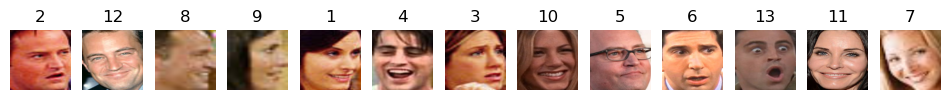

In [7]:
fc.plot_faces2()

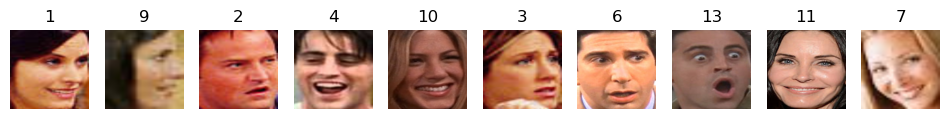

In [8]:
fc.merge_faces([2,12,8,5],True)

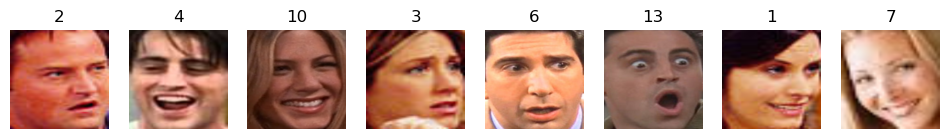

In [9]:
fc.merge_faces([1,9,11],True)

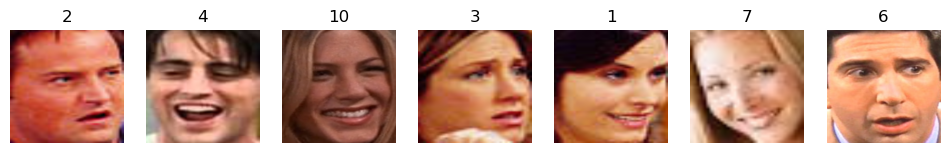

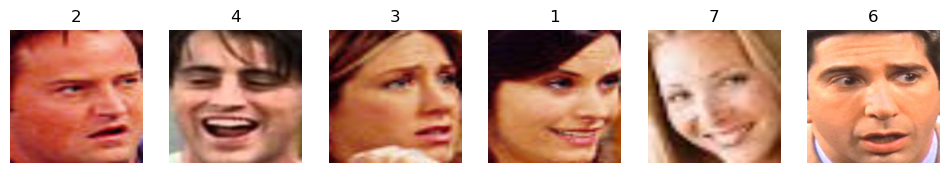

In [10]:
fc.merge_faces([4,13],True)
fc.merge_faces([10,3],True)

In [11]:
fc.save_faces('Output3/')

Copied 'Images/img19.jpg' to 'Output3/1/img19.jpg'
Copied 'Images/img1.jpg' to 'Output3/1/img1.jpg'
Copied 'Images/img4.jpg' to 'Output3/1/img4.jpg'
Copied 'Images/img20.webp' to 'Output3/1/img20.webp'
Copied 'Images/img2.jpg' to 'Output3/1/img2.jpg'
Copied 'Images/img9.jpg' to 'Output3/2/img9.jpg'
Copied 'Images/img3.jpg' to 'Output3/2/img3.jpg'
Copied 'Images/img1.jpg' to 'Output3/2/img1.jpg'
Copied 'Images/img11.jpg' to 'Output3/2/img11.jpg'
Copied 'Images/img5.jpg' to 'Output3/2/img5.jpg'
Copied 'Images/img13.jpg' to 'Output3/2/img13.jpg'
Copied 'Images/img14.jpg' to 'Output3/2/img14.jpg'
Copied 'Images/img2.jpg' to 'Output3/2/img2.jpg'
Copied 'Images/img1.jpg' to 'Output3/3/img1.jpg'
Copied 'Images/img2.jpg' to 'Output3/3/img2.jpg'
Copied 'Images/img5.jpg' to 'Output3/3/img5.jpg'
Copied 'Images/img22.webp' to 'Output3/3/img22.webp'
Copied 'Images/img21.jpg' to 'Output3/3/img21.jpg'
Copied 'Images/img10.jpg' to 'Output3/4/img10.jpg'
Copied 'Images/img3.jpg' to 'Output3/4/img3.jpg'


In [12]:
with open('friends_fc.pkl','wb') as file:
    pickle.dump(fc,file)

In [13]:
import pickle
with open('friends_fc.pkl','rb') as file:
    fc = pickle.load(file)

In [28]:
import cv2

cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    cv2.imshow('Camera', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if cv2.waitKey(1) & 0xFF == ord('s'):
        filename = f"find.jpg"
        cv2.imwrite(filename, frame)
        print(f"Image saved as {filename}")
cap.release()
cv2.destroyAllWindows()

Image saved as find.jpg


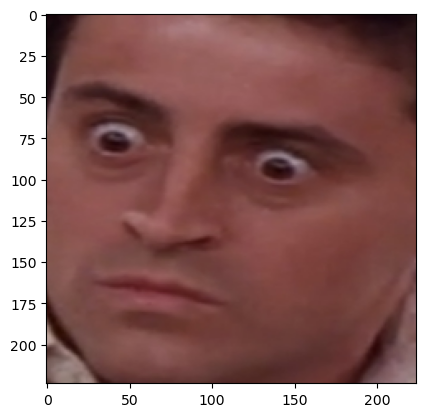

1/1 [==============================] - 0s 297ms/step
[(0.5545400381088257, 4)]
found 5 images


In [14]:
fc.find_images('find.jpg',threshold=0.6)

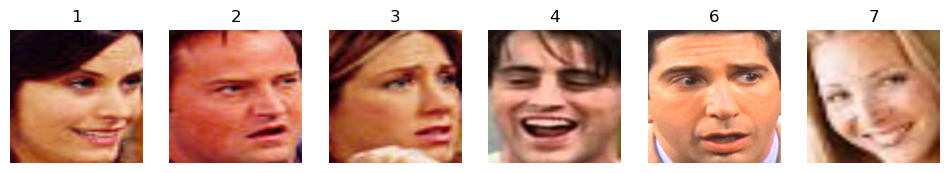

In [15]:
fc.plot_faces()

In [16]:
fc.save_found_images('found/')

Copied 'Images/img8.jpg' to 'found/img8.jpg'
Copied 'Images/img7.jpg' to 'found/img7.jpg'
Copied 'Images/img10.jpg' to 'found/img10.jpg'
Copied 'Images/img3.jpg' to 'found/img3.jpg'
Copied 'Images/img12.jpg' to 'found/img12.jpg'
